<a href="https://colab.research.google.com/github/gabrielebilliciani/knowledge-distillation/blob/main/Notebook1_KD_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation for Regression

 > **Note**: This notebook is part of an introductory project on Knowledge Distillation. It serves as a practical companion to the main presentation slides. The complete project is available on GitHub at: https://github.com/gabrielebilliciani/knowledge-distillation

This notebook provides a practical demonstration of **Knowledge Distillation (KD)** applied to a regression task. The core principle of KD is to transfer "knowledge" from a large, complex, and high-performing **teacher** model to a smaller, more efficient **student** model. The goal is to enable the student to achieve performance that surpasses what it could learn on its own, thereby creating a model that is both accurate and computationally inexpensive.

### Teacher & Student Architecture Philosophy

We will design our models with distinct roles in mind:
*   **Teacher Model:** A deep neural network (6-8 fully-connected layers) with a high capacity to learn complex mappings from the data. It will use advanced activation functions like **Leaky Rectified Linear Unit (LeakyReLU)** or **Exponential Linear Unit (ELU)** to capture nuanced patterns and prevent issues like dying neurons.
*   **Student Model:** A much shallower network (2-3 fully-connected layers) using the standard **Rectified Linear Unit (ReLU)** activation. This model is designed for simplicity, faster inference, and a lower memory footprint, making it suitable for deployment in resource-constrained environments.

### Distillation Loss Function

To transfer knowledge, the student will be trained to optimise a composite loss function that combines signals from the ground truth data and the teacher's output predictions

The combined loss function, $L$, is a weighted sum of two components:
$$
L = \lambda_1 \|y - y^{(s)}\|^2 + \lambda_2 \|y^{(t)} - y^{(s)}\|^2
$$

Where:
*   **Term 1 (Hard Loss):** The standard regression loss (Mean Squared Error) between the **ground truth target** ($y$) and the **student's prediction** ($y^{(s)}$). This ensures the student learns the primary task. $\lambda_1$ controls its weight.

*   **Term 2 ($L_{HP}$ - High Precision Distillation):** The L2 distance between the **teacher's prediction** ($y^{(t)}$) and the **student's prediction** ($y^{(s)}$). This is the classic distillation signal, where the student mimics the teacher's output. These "soft targets" from the teacher provide richer information than the hard ground truth labels alone.

### Notebook Goal

In this experiment, we will:
1.  Define and pre-train a powerful teacher model on a dataset.
2.  Train a simple student model from scratch as a baseline.
3.  Train a second student using Hard Loss and $L_{HP}$ distillation (Terms 1 & 2).
4.  Compare the performance of all models on a held-out test set to evaluate the effectiveness of each distillation technique.

# 1. Setup, Configuration and Data Preparation

## Imports and Configuration

First, we import the necessary libraries and set up the main configuration parameters for the experiment. This includes defining the device (GPU or CPU), training hyperparameters like learning rates and batch sizes, and the parameters for generating our synthetic data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Configuration ---

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data generation parameters
N_SAMPLES = 2000
X_MIN, X_MAX = -4, 4
NOISE_LEVEL = 0.1

# Training hyperparameters
BATCH_SIZE = 128
EPOCHS_TEACHER = 700
EPOCHS_STUDENT = 600
LR_TEACHER = 1e-4
LR_STUDENT = 1e-3
EARLY_STOPPING_PATIENCE = 50 # NEW: Patience for early stopping

# --- CHANGE: Re-balanced distillation loss weights for new strategies ---
# These are dictionaries that will be passed to the training function

# Weights for the student trained only on teacher's predictions (L_HP)
HP_ONLY_WEIGHTS = {'hard': 0.3, 'hp': 0.7}

# Weights for the student trained on predictions and intermediate features (L_HP + L_FEAT)
HP_FEAT_WEIGHTS = {'hard': 0.3, 'hp': 0.4, 'feat': 0.3}


# Number of runs for statistical analysis
N_RUNS = 5

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Using device: cuda


## 1.1 Data Generation and Preprocessing

For this experiment, we will create a **synthetic dataset** to provide a challenging learning environment for our models. The key advantage of a synthetic dataset is that we can precisely control the true underlying function and the level of noise, allowing for a clear evaluation of model performance.

**Data Generation:** We generate `X` features and a target `y` based on a function that is deliberately complex and hard to approximate. It combines several mathematical properties to test a model's flexibility:
*   **Non-linear and periodic terms** (sine, cosine)
*   **Feature interactions** (e.g. `feature1 * feature2`)
*   **A sharp discontinuity** (a step-like change)
*   **Irrelevant "noise" features** that the model must learn to ignore.

Gaussian noise is added to the final output to simulate real-world measurement error.

**Feature Scaling:** The input features are standardised using `StandardScaler` to have a mean of 0 and a standard variance of 1. This is a crucial preprocessing step for neural networks, as it stabilises training and helps the model converge more efficiently.

In [ ]:
N_FEATURES = 10

def generate_highly_complex_data(n_samples, n_features, noise_level):
    """
    Generates data from a complex, non-linear function of multiple features.
    """
    np.random.seed(42)
    X = np.random.uniform(-2, 2, (n_samples, n_features))

    # A complex function involving feature interactions
    # Some features are more important than others
    y_true = (np.sin(X[:, 0] * X[:, 1]) +            # Interaction term
              0.5 * np.cos(X[:, 2] * np.pi) +        # Periodic term
              np.tanh(X[:, 3]) +                     # Non-linear saturation
              0.2 * X[:, 4]**2 -                     # Quadratic term
              1.5 * np.exp(-X[:, 0]**2) +            # Gaussian term
              0.1 * (X[:, 5] > 0).astype(float))   # Discontinuity

    # Add some noise
    y_noisy = y_true + np.random.normal(0, noise_level, y_true.shape)

    # Ensure y has the shape (n_samples, 1)
    return X.astype(np.float32), y_noisy.reshape(-1, 1).astype(np.float32), y_true.reshape(-1, 1).astype(np.float32)

# 1. Generate Data
X, y, y_true_func = generate_highly_complex_data(N_SAMPLES, N_FEATURES, NOISE_LEVEL)

# 2. Split into initial training/testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Split the training data into new training and validation sets
# We'll use 20% of the training data for validation (0.2 * 0.8 = 0.16 of the total data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# 4. Scale the features (FIT ONLY ON TRAINING DATA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5. Convert to PyTorch tensors and move to device
X_train_tensor = torch.from_numpy(X_train_scaled).to(device)
y_train_tensor = torch.from_numpy(y_train).to(device)
X_val_tensor = torch.from_numpy(X_val_scaled).to(device)
y_val_tensor = torch.from_numpy(y_val).to(device)
X_test_tensor = torch.from_numpy(X_test_scaled).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)

# 6. Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data shapes:")
print(f"  X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"  X_val:   {X_val_tensor.shape}, y_val:   {y_val_tensor.shape}")
print(f"  X_test:  {X_test_tensor.shape}, y_test:  {y_test_tensor.shape}")

# Visualization is not meaningful for 10D data, so we'll skip it.

Data shapes:
  X_train: torch.Size([1280, 10]), y_train: torch.Size([1280, 1])
  X_val:   torch.Size([320, 10]), y_val:   torch.Size([320, 1])
  X_test:  torch.Size([400, 10]), y_test:  torch.Size([400, 1])


# 2. A Standard Distillation Attempt

In our first experiment, we will test the foundational hypothesis of knowledge distillation. We will create:
1.  A **Teacher Model**: A deep network using `LeakyReLU` activations. It's powerful but does not use extra regularisation like Dropout. We'll simply call it `TeacherNet`.
2.  A **Student Model**: A smaller, less complex network that uses only standard `ReLU` activations, making it suitable for analysis with tools like ReLUplex.

We will compare three models:
- The Teacher model's performance.
- The Student model trained from scratch (our baseline).
- The Student model distilled from the Teacher.

Our hypothesis is that on this complex task, the distilled student should be able to outperform the student trained from scratch.

In [ ]:
# --- Models and Training Functions for Part 1 (with Early Stopping) ---

# The first teacher: Deeper, with LeakyReLU but no Dropout.
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(N_FEATURES, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.layers(x)

# The student model
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(N_FEATURES, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

# Loss function
criterion = nn.MSELoss()

# --- Helper Functions with TQDM and Early Stopping ---

def train_model(model, train_loader, val_loader, optimizer, epochs, patience, pbar):
    """Standard training loop with an outer tqdm progress bar and early stopping."""
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = model(X_val_batch)
                loss = criterion(val_outputs, y_val_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        pbar.set_postfix_str(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            pbar.set_postfix_str(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            pbar.update(epochs - epoch - 1) # Fast-forward the progress bar
            break

        pbar.update(1)

    # Load the best model state before returning
    if best_model_state:
        model.load_state_dict(best_model_state)
    return model


def train_student_distilled_fixed(student_model, teacher_model, train_loader, val_loader, optimizer, epochs, patience, pbar):
    """Distillation training with FIXED weights, an outer tqdm progress bar, and early stopping."""
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    weights = {'hard': 0.3, 'hp': 0.7}

    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        for X_batch, y_batch_true in train_loader:
            optimizer.zero_grad()
            y_pred_student = student_model(X_batch)
            with torch.no_grad():
                y_pred_teacher = teacher_model(X_batch)
            loss_hard = criterion(y_pred_student, y_batch_true)
            loss_soft_hp = criterion(y_pred_student, y_pred_teacher)
            combined_loss = weights['hard'] * loss_hard + weights['hp'] * loss_soft_hp
            combined_loss.backward()
            optimizer.step()

        # Validation step (using only hard loss for validation)
        student_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = student_model(X_val_batch)
                loss = criterion(val_outputs, y_val_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        pbar.set_postfix_str(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = student_model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            pbar.set_postfix_str(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            pbar.update(epochs - epoch - 1) # Fast-forward progress bar
            break

        pbar.update(1)

    # Load the best model state
    if best_model_state:
        student_model.load_state_dict(best_model_state)
    return student_model


def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()
    mse = mean_squared_error(y_tensor.cpu().numpy(), y_pred)
    r2 = r2_score(y_tensor.cpu().numpy(), y_pred)
    return y_pred, mse, r2

In [ ]:
# --- Part 1: Experiment Execution (with Early Stopping) ---

# Max number of epochs; training may stop earlier.
EPOCHS_STUDENT = 600
EPOCHS_TEACHER = 700

initial_student_states = []
part1_results = {
    "Teacher": {'mse': [], 'r2': []},
    "Student (Scratch)": {'mse': [], 'r2': []},
    "Student (Distilled)": {'mse': [], 'r2': []}
}

# --- Main progress bar for the runs ---
with tqdm(total=N_RUNS, desc="Overall Progress") as run_pbar:
    for i in range(N_RUNS):
        run_pbar.set_description(f"Run {i+1}/{N_RUNS}")
        torch.manual_seed(i); np.random.seed(i)

        template_student = StudentNet().to(device)
        initial_student_states.append(template_student.state_dict())

        # --- Train Teacher ---
        run_pbar.set_postfix_str("Training Teacher...")
        teacher = TeacherNet().to(device)
        optimizer_teacher = optim.Adam(teacher.parameters(), lr=LR_TEACHER, weight_decay=1e-5)
        with tqdm(total=EPOCHS_TEACHER, desc="Teacher Training", leave=False) as epoch_pbar:
            teacher = train_model(
                teacher, train_loader, val_loader, optimizer_teacher,
                EPOCHS_TEACHER, EARLY_STOPPING_PATIENCE, epoch_pbar
            )

        # --- Train Student (Scratch) ---
        run_pbar.set_postfix_str("Training Student (Scratch)...")
        student_scratch = StudentNet().to(device)
        student_scratch.load_state_dict(initial_student_states[i])
        optimizer_scratch = optim.Adam(student_scratch.parameters(), lr=LR_STUDENT)
        with tqdm(total=EPOCHS_STUDENT, desc="Student (Scratch) Training", leave=False) as epoch_pbar:
            student_scratch = train_model(
                student_scratch, train_loader, val_loader, optimizer_scratch,
                EPOCHS_STUDENT, EARLY_STOPPING_PATIENCE, epoch_pbar
            )

        # --- Train Student (Distilled) ---
        run_pbar.set_postfix_str("Training Student (Distilled)...")
        student_distilled = StudentNet().to(device)
        student_distilled.load_state_dict(initial_student_states[i])
        optimizer_distill = optim.Adam(student_distilled.parameters(), lr=LR_STUDENT)
        with tqdm(total=EPOCHS_STUDENT, desc="Student (Distilled) Training", leave=False) as epoch_pbar:
            student_distilled = train_student_distilled_fixed(
                student_distilled, teacher, train_loader, val_loader, optimizer_distill,
                EPOCHS_STUDENT, EARLY_STOPPING_PATIENCE, epoch_pbar
            )

        # --- Evaluation --
        # Evaluation is still done on the final, held-out test set
        run_pbar.set_postfix_str("Evaluating...")
        _, mse_t, r2_t = evaluate_model(teacher, X_test_tensor, y_test_tensor)
        _, mse_s, r2_s = evaluate_model(student_scratch, X_test_tensor, y_test_tensor)
        _, mse_d, r2_d = evaluate_model(student_distilled, X_test_tensor, y_test_tensor)

        part1_results["Teacher"]['mse'].append(mse_t); part1_results["Teacher"]['r2'].append(r2_t)
        part1_results["Student (Scratch)"]['mse'].append(mse_s); part1_results["Student (Scratch)"]['r2'].append(r2_s)
        part1_results["Student (Distilled)"]['mse'].append(mse_d); part1_results["Student (Distilled)"]['r2'].append(r2_d)

        run_pbar.update(1)

# --- Results Table for Part 1 ---
print(f"\n{'='*20} RESULTS FOR PART 1 (over {N_RUNS} runs) {'='*20}")
print(f"{'Model':<25} | {'Mean MSE':<15} | {'Std Dev MSE':<15} | {'Mean R2':<15}")
print('-'*75)
for name, data in part1_results.items():
    print(f"{name:<25} | {np.mean(data['mse']):<15.4f} | {np.std(data['mse']):<15.4f} | {np.mean(data['r2']):<15.4f}")

# --- Statistical Test for Part 1 ---
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(part1_results["Student (Distilled)"]['mse'], part1_results["Student (Scratch)"]['mse'], alternative='less')
improvement = (np.mean(part1_results["Student (Scratch)"]['mse']) - np.mean(part1_results["Student (Distilled)"]['mse'])) / np.mean(part1_results["Student (Scratch)"]['mse']) * 100

print('\n' + '-'*75)
print(f"Improvement of Distilled vs. Scratch: {improvement:.2f}% (p-value: {p_val:.4f})")
print('-'*75)

Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Teacher Training:   0%|          | 0/700 [00:00<?, ?it/s]

Student (Scratch) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Student (Distilled) Training:   0%|          | 0/600 [00:00<?, ?it/s]


==================== RESULTS FOR PART 1 (over 5 runs) ====================
Model                     | Mean MSE        | Std Dev MSE     | Mean R2        
---------------------------------------------------------------------------
Teacher                   | 0.3194          | 0.0102          | 0.7705         
Student (Scratch)         | 0.3436          | 0.0158          | 0.7531         
Student (Distilled)       | 0.3357          | 0.0154          | 0.7588         

---------------------------------------------------------------------------
Improvement of Distilled vs. Scratch: 2.32% (p-value: 0.1857)
---------------------------------------------------------------------------


# 3. Improving the Teacher

### Analysis of Part 1 Results

The results from our first experiment show a slight improvement. On average, the distilled student achieved a lower Mean Squared Error (0.3357) compared to the student trained from scratch (0.3436). However, this improvement of 2.32% was not found to be statistically significant over the five runs (p-value = 0.1857). This suggests that while there might be a small benefit, the "knowledge" from the standard teacher isn't consistently strong enough to elevate the student significantly.

This leads to a key question: **If we use an even better teacher, can we produce an even better student?**

### Hypothesis

Our new hypothesis is that by enhancing the teacher's architecture with techniques that improve generalisation (like **Dropout**) and learning capacity (like **LeakyReLU** and **Batch Normalisation**), we can create an "Expert Teacher". Distilling from this expert teacher should yield a student that is significantly better than both the scratch baseline *and* the student distilled from the standard teacher.

To test this, we will now:
1.  Define a new `ExpertTeacherNet`.
2.  Train it on our complex task.
3.  Distil its knowledge into a new student, **ensuring the student starts from the exact same initial weights as in Part 1** for a fair comparison.
4.  Compare the performance of all models.

In [ ]:
class ExpertTeacherNet(nn.Module):
    def __init__(self):
        super(ExpertTeacherNet, self).__init__()
        # For a very large network, we need stronger dropout to prevent overfitting.
        p_drop = 0.4

        self.layers = nn.Sequential(
            # --- Block 1 (Input) ---
            nn.Linear(N_FEATURES, 512), # WIDENED
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=p_drop),

            # --- Block 2 ---
            nn.Linear(512, 512), # WIDENED
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=p_drop),

            # --- Block 3 ---
            nn.Linear(512, 256), # WIDENED
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=p_drop),

            # --- Block 4 ---
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=p_drop),

            # --- Block 5 (Output) ---
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# --- Part 2: Final Experiment Execution and Comprehensive Results with TQDM ---
EARLY_STOPPING_PATIENCE_TEACHER = 100
EPOCHS_TEACHER = 1000

expert_teacher_results = {'mse': [], 'r2': []}
student_distilled_expert_results = {'mse': [], 'r2': []}

part2_model_states = []

with tqdm(total=N_RUNS, desc="Overall Progress (Part 2)") as run_pbar:
    for i in range(N_RUNS):
        run_pbar.set_description(f"Run {i+1}/{N_RUNS}")
        torch.manual_seed(i); np.random.seed(i)

        # --- Train Expert Teacher ---
        run_pbar.set_postfix_str("Training Expert Teacher...")
        expert_teacher = ExpertTeacherNet().to(device)
        optimizer_expert = optim.Adam(expert_teacher.parameters(), lr=LR_TEACHER, weight_decay=1e-4)
        with tqdm(total=EPOCHS_TEACHER, desc="Expert Teacher Training", leave=False) as epoch_pbar:
            expert_teacher = train_model(
                expert_teacher, train_loader, val_loader, optimizer_expert,
                EPOCHS_TEACHER, EARLY_STOPPING_PATIENCE_TEACHER, epoch_pbar
            )

        # --- Distill from EXPERT Teacher ---
        run_pbar.set_postfix_str("Training Student (from Expert)...")
        student_distilled_expert = StudentNet().to(device)
        student_distilled_expert.load_state_dict(initial_student_states[i])
        optimizer_distill_expert = optim.Adam(student_distilled_expert.parameters(), lr=LR_STUDENT)
        with tqdm(total=EPOCHS_STUDENT, desc="Student (from Expert) Training", leave=False) as epoch_pbar:
            student_distilled_expert = train_student_distilled_fixed(
                student_distilled_expert, expert_teacher, train_loader, val_loader,
                optimizer_distill_expert, EPOCHS_STUDENT, EARLY_STOPPING_PATIENCE, epoch_pbar
            )

        # --- Evaluation ---
        run_pbar.set_postfix_str("Evaluating...")
        _, mse_exp_t, r2_exp_t = evaluate_model(expert_teacher, X_test_tensor, y_test_tensor)
        _, mse_dist_exp, r2_dist_exp = evaluate_model(student_distilled_expert, X_test_tensor, y_test_tensor)

        expert_teacher_results['mse'].append(mse_exp_t); expert_teacher_results['r2'].append(r2_exp_t)
        student_distilled_expert_results['mse'].append(mse_dist_exp); student_distilled_expert_results['r2'].append(r2_dist_exp)

        # Save the states for this run (for potential use in Part 3 and 4)
        part2_model_states.append({
            'expert_teacher': expert_teacher.state_dict(),
            'student_distilled_expert': student_distilled_expert.state_dict()
        })

        run_pbar.update(1)

# --- Combine all results into one dictionary for the final table ---
final_results = {
    "Standard Teacher": part1_results["Teacher"],
    "Expert Teacher": expert_teacher_results,
    "Student (Scratch)": part1_results["Student (Scratch)"],
    "Student (Distilled from Standard)": part1_results["Student (Distilled)"],
    "Student (Distilled from Expert)": student_distilled_expert_results
}

# --- Final Aggregated Results Table ---
print(f"\n{'='*20} FINAL COMPREHENSIVE RESULTS (over {N_RUNS} runs) {'='*20}")
print(f"{'Model':<40} | {'Mean MSE':<15} | {'Std Dev MSE':<15} | {'Mean R2':<15}")
print('-'*90)
for name, data in final_results.items():
    print(f"{name:<40} | {np.mean(data['mse']):<15.4f} | {np.std(data['mse']):<15.4f} | {np.mean(data['r2']):<15.4f}")

# --- Calculate and Print Improvement ---
mean_mse_scratch = np.mean(final_results["Student (Scratch)"]['mse'])
mean_mse_dist_std = np.mean(final_results["Student (Distilled from Standard)"]['mse'])
mean_mse_dist_exp = np.mean(final_results["Student (Distilled from Expert)"]['mse'])
improvement_std = (mean_mse_scratch - mean_mse_dist_std) / mean_mse_scratch * 100
improvement_exp = (mean_mse_scratch - mean_mse_dist_exp) / mean_mse_scratch * 100

print('\n' + '-'*90)
print("Average MSE Improvement over Student (Scratch):")
print(f"Distillation from Standard Teacher:      {improvement_std:.2f}%")
print(f"Distillation from Expert Teacher:        {improvement_exp:.2f}%")
print('-'*90)

# --- Statistical Tests ---
from scipy.stats import ttest_rel
t_stat_std, p_val_std = ttest_rel(final_results["Student (Distilled from Standard)"]['mse'], final_results["Student (Scratch)"]['mse'], alternative='less')
t_stat_exp, p_val_exp = ttest_rel(final_results["Student (Distilled from Expert)"]['mse'], final_results["Student (Scratch)"]['mse'], alternative='less')
print("\n" + "="*20 + " Statistical Significance Tests " + "="*20)
print("\nComparing vs. Student (Scratch):")
print(f"Standard Teacher Distillation:  p-value = {p_val_std:.4f}")
print(f"Expert Teacher Distillation:    p-value = {p_val_exp:.4f}")
print("="*68)

Overall Progress (Part 2):   0%|          | 0/5 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]

Expert Teacher Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Student (from Expert) Training:   0%|          | 0/600 [00:00<?, ?it/s]


==================== FINAL COMPREHENSIVE RESULTS (over 5 runs) ====================
Model                                    | Mean MSE        | Std Dev MSE     | Mean R2        
------------------------------------------------------------------------------------------
Standard Teacher                         | 0.3194          | 0.0102          | 0.7705         
Expert Teacher                           | 0.2717          | 0.0078          | 0.8048         
Student (Scratch)                        | 0.3436          | 0.0158          | 0.7531         
Student (Distilled from Standard)        | 0.3357          | 0.0154          | 0.7588         
Student (Distilled from Expert)          | 0.3185          | 0.0147          | 0.7712         

------------------------------------------------------------------------------------------
Average MSE Improvement over Student (Scratch):
Distillation from Standard Teacher:      2.32%
Distillation from Expert Teacher:        7.31%
--------------------

# 4. Optimising Distillation Weights via Grid Search

### Analysis of new results
The results from Part 2 are definitive: using a more powerful, regularised **Expert Teacher** provides a substantial and statistically significant improvement. This confirms our main hypothesis that a better teacher makes a better student.

However, the distillation process itself used a fixed, heuristic weight balance (`hard_loss`: 0.3, `hp_loss`: 0.7). This ratio was chosen intuitively, but is it optimal?

### Next steps
The balance between learning from the ground truth (`hard_loss`) and mimicking the teacher's predictions (`hp_loss`) is a critical hyperparameter. By systematically searching for the best balance, we can further improve the student's performance beyond our initial guess.

To test this, we will perform a grid search. For each run and for each weight combination, we will:
1.  Load the pre-trained **Expert Teacher** from the previous experiment.
2.  Initialize a **brand-new student** using the *exact same starting weights* as all other students in this notebook.
3.  Train this student using the same **early stopping** mechanism used for all other models to ensure a fair comparison. The model that performs best on the validation set will be selected.
4.  Evaluate its performance on the final test set and average the results across all `N_RUNS` to find the most effective weighting strategy.

Grid Search Full Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.1:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.3:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.5:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.7:   0%|          | 0/600 [00:00<?, ?it/s]

Training H=0.9:   0%|          | 0/600 [00:00<?, ?it/s]

\n==================== RESULTS FOR PART 3: GRID SEARCH (over 5 runs) ====================
        Weights  Mean MSE  Std Dev MSE   Mean R2
0  H=0.3_HP=0.7  0.310855     0.017177  0.776657
1  H=0.1_HP=0.9  0.314427     0.008988  0.774090
2  H=0.7_HP=0.3  0.318653     0.012933  0.771054
3  H=0.5_HP=0.5  0.322715     0.020620  0.768135
4  H=0.9_HP=0.1  0.341145     0.019921  0.754894
\nBest performance achieved with weights: H=0.3_HP=0.7


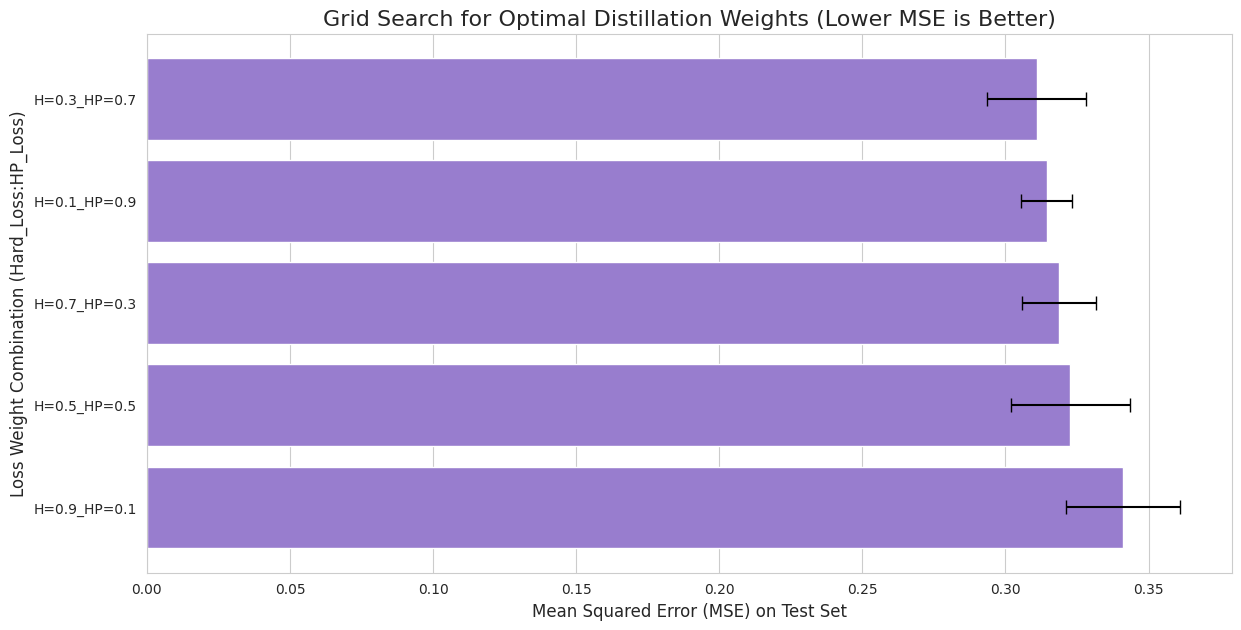

In [ ]:
import pandas as pd

# --- Configuration for Part 3 Grid Search ---\n",
# We use the original student hyperparameters
LR_GRID_SEARCH = LR_STUDENT
EPOCHS_GRID_SEARCH = EPOCHS_STUDENT

# Define the grid of weights to search
weight_combinations = [
    {'hard': 0.1, 'hp': 0.9},
    {'hard': 0.3, 'hp': 0.7}, # The original weights from Part 2
    {'hard': 0.5, 'hp': 0.5},
    {'hard': 0.7, 'hp': 0.3},
    {'hard': 0.9, 'hp': 0.1},
]

# Store results for each weight combination
grid_search_results = {f"H={w['hard']}_HP={w['hp']}": {'mse': [], 'r2': []} for w in weight_combinations}

# A distillation trainer that accepts weights and performs early stopping
def train_student_distilled_early_stopping(student_model, teacher_model, train_loader, val_loader, optimizer, epochs, patience, pbar, weights):
    """Distillation training with a flexible weights dictionary and early stopping."""
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        student_model.train()
        teacher_model.eval()
        for X_batch, y_batch_true in train_loader:
            optimizer.zero_grad()
            y_pred_student = student_model(X_batch)
            with torch.no_grad():
                y_pred_teacher = teacher_model(X_batch)
            loss_hard = criterion(y_pred_student, y_batch_true)
            loss_soft_hp = criterion(y_pred_student, y_pred_teacher)
            combined_loss = weights['hard'] * loss_hard + weights['hp'] * loss_soft_hp
            combined_loss.backward()
            optimizer.step()

        # Validation step
        student_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = student_model(X_val_batch)
                loss = criterion(val_outputs, y_val_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        pbar.set_postfix_str(f"Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = student_model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            pbar.set_postfix_str(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            pbar.update(epochs - epoch - 1)
            break

        pbar.update(1)

    # Load the best model state
    if best_model_state:
        student_model.load_state_dict(best_model_state)
    return student_model

# --- Main Grid Search Loop (with Early Stopping) ---\n",
with tqdm(total=N_RUNS * len(weight_combinations), desc="Grid Search Full Training") as pbar:
    for i in range(N_RUNS):
        # Load the expert teacher from this specific run in Part 2
        expert_teacher = ExpertTeacherNet().to(device)
        expert_teacher.load_state_dict(part2_model_states[i]['expert_teacher'])

        # The initial student state for this run
        student_initial_state = initial_student_states[i]

        for weights in weight_combinations:
            pbar.set_description(f"Run {i+1}, Weights H={weights['hard']}:HP={weights['hp']}")

            # Re-initialize student and optimizer for each grid point
            student_to_train = StudentNet().to(device)
            student_to_train.load_state_dict(student_initial_state)
            optimizer = optim.Adam(student_to_train.parameters(), lr=LR_GRID_SEARCH)

            # Train the model with early stopping
            with tqdm(total=EPOCHS_GRID_SEARCH, desc=f"Training H={weights['hard']}", leave=False) as epoch_pbar:
                student_to_train = train_student_distilled_early_stopping(
                    student_to_train, expert_teacher, train_loader, val_loader, optimizer,
                    EPOCHS_GRID_SEARCH, EARLY_STOPPING_PATIENCE, epoch_pbar, weights
                )

            # Evaluate and store the results
            _, mse, r2 = evaluate_model(student_to_train, X_test_tensor, y_test_tensor)
            key = f"H={weights['hard']}_HP={weights['hp']}"
            grid_search_results[key]['mse'].append(mse)
            grid_search_results[key]['r2'].append(r2)

            pbar.update(1)

# --- Process and Display Grid Search Results ---\n",
results_df_data = []
for name, data in grid_search_results.items():
    results_df_data.append({
        'Weights': name,
        'Mean MSE': np.mean(data['mse']),
        'Std Dev MSE': np.std(data['mse']),
        'Mean R2': np.mean(data['r2'])
    })

results_df = pd.DataFrame(results_df_data).sort_values(by='Mean MSE').reset_index(drop=True)

# Identify the best result from the grid search
best_grid_search_result = results_df.iloc[0]
best_grid_search_name = "Student (Distilled, Optimal HP Weights)"
best_grid_search_stats = grid_search_results[best_grid_search_result['Weights']]

print(f"\\n{'='*20} RESULTS FOR PART 3: GRID SEARCH (over {N_RUNS} runs) {'='*20}")
print(results_df.to_string())
print(f"\\nBest performance achieved with weights: {best_grid_search_result['Weights']}")

# --- Visualize the Grid Search Results ---\n",
plt.figure(figsize=(14, 7))
sns.barplot(x='Mean MSE', y='Weights', data=results_df, orient='h', color='mediumpurple')
plt.errorbar(x=results_df['Mean MSE'], y=results_df.index, xerr=results_df['Std Dev MSE'], fmt='none', c='black', capsize=5)
plt.title('Grid Search for Optimal Distillation Weights (Lower MSE is Better)', fontsize=16)
plt.xlabel('Mean Squared Error (MSE) on Test Set', fontsize=12)
plt.ylabel('Loss Weight Combination (Hard_Loss:HP_Loss)', fontsize=12)
plt.grid(True, axis='x')
plt.show()

### Comment
The grid search results are insightful. While giving a heavy weighting to the teacher's predictions (e.g., `HP=0.9`) yields a strong performance, the optimal balance was found at `H=0.3_HP=0.7`. This suggests that while the teacher's knowledge is highly valuable, grounding the student in the ground truth data is still crucial for achieving the best possible performance. Simply mimicking the teacher is not enough; a blend of both signals is key.

Of course, this is highly dependent on the task at hand: this notebook is a toy example and as often happens in machine learning, the results may not generalise to other tasks. However, the principles of knowledge distillation and the importance of teacher quality remain valid across various domains.

### Final Conclusion and Further Insights

This experiment has demonstrated a case where knowledge distillation can successfully improve the performance of a smaller student model in a regression task. The most effective strategy in this particular setup was to:

1.  **Train a highly capable and well-regularised Teacher model.** A better teacher provides higher-quality "soft targets", leading to a better student.
2.  **Perform response-based distillation (`L_HP`).** This classic technique proved robust and effective.
3.  **Carefully tune the distillation hyperparameters.** A grid search revealed that the optimal balance between learning from the ground truth (`hard_loss`) and mimicking the teacher (`hp_loss`) was critical for maximising performance.

It is worth noting that this notebook is a simplified example. In our broader explorations, we also experimented with adding other distillation signals, such as matching input gradients or intermediate feature representations. However, their effect was not consistently positive and did not yield a clear improvement over the tuned `L_HP` method, so they were not included here for clarity.

Based on our experiments, we have gathered several insights for practitioners interested in applying distillation to regression:

*   **Task Complexity Matters:** We observed no significant improvements from distillation on overly simple tasks. The problem needs to be complex enough that the teacher can learn "dark knowledge"—a mapping that is richer than the ground truth labels alone.
*   **Teacher Quality is Paramount:** As demonstrated, a more powerful teacher leads to a better distilled student.
*   **Student Capacity is Important:** The student model must have sufficient capacity to capture the nuances of the teacher's predictions. If the student is too small, it may not be able to benefit from the richer signal.
*   **Statistical Validation is Crucial:** In some experiments, a single run of distillation showed significant improvements. However, when repeated for statistical validation, we found that on average, training from scratch could sometimes achieve a comparable performance. The inherent randomness in training can be a significant confounding factor, and a single successful run should be treated with caution.

Ultimately, we have not found distillation in regression to be as universally and dramatically effective as it often is in classification tasks. This is consistent with the literature, where distillation is much more commonly and successfully applied to classification. Indeed, in our own classification experiments, we achieved excellent results, which can be seen in the following notebooks:
*   [Notebook 2: Distillation for Classification](link-to-notebook-2)
*   [Notebook 3: Advanced Distillation Techniques](link-to-notebook-3)

Knowledge distillation remains something of an art: you need to experiment and find the right balance of models, data, and techniques for your specific task to achieve optimal results.